In [17]:
from collections import namedtuple
import json
import matplotlib.pyplot as plt
import pandas as pd
import requests

try:
  import geopandas as gpd
except ModuleNotFoundError:
  !pip install geopandas
  import geopandas as gpd

#get the Folium library for map generation
try:
    import folium
except ModuleNotFoundError:
    !pip install folium -q 
    import folium
    
#get the descartes library for map generation
try:
    import descartes
except ModuleNotFoundError:
    !pip install descartes -q 
    import descartes


In [18]:
# Read in the data from the URL with Python's requests library
url = 'https://gcc.azure-api.net/traffic/carparks?format=json'
response = requests.get(url)
data = response.json()

In [19]:
# Coordinates = namedtuple('Coordinates', 'latitude longitude')

def extract_parking_data(data: dict) -> pd.DataFrame:
    data = data['d2lm$d2LogicalModel']['d2lm$payloadPublication']['d2lm$situation']
    
    parking_records = []
    for record in data:
        location_data = record['d2lm$situationRecord']
        coords_pt = location_data['d2lm$groupOfLocations']['d2lm$locationContainedInGroup']['d2lm$pointByCoordinates']
        coords_pt = coords_pt['d2lm$pointCoordinates']
        lat = coords_pt['d2lm$latitude']
        long = coords_pt['d2lm$longitude']
        spaces_available = int(location_data['d2lm$totalCapacity']) - int(location_data['d2lm$occupiedSpaces'])
        name = location_data['d2lm$carParkIdentity']
        parking_records.append({
            'name': name,
            'latitude': lat,
            'longitude': long,
            'spaces': spaces_available
        })
    return pd.DataFrame(parking_records)

df = extract_parking_data(data)

df.head(9)

,name,latitude,longitude,spaces
0,Glasgow - SECC:CPG25C,55.85988984843241,-4.282341367108816,1090
1,Glasgow - Duke Street Car Park:CPG24C,55.85966175538049,-4.236528758151018,1081
2,Glasgow - Dundasvale Car Park 2:CPG21C,55.869167760473324,-4.258813645522479,37
3,Glasgow - Royal Infirmary Car Pa:CPG15C,55.86548682162141,-4.23497771554331,1749
4,Glasgow - George Street Car Park:CPG14C,55.86123812209307,-4.244721620331509,1289
5,Glasgow - High Street Pay &amp; Disp:CPG13C,55.85977254007017,-4.239331652385187,0
6,Glasgow - The Glasshouse Car Par:CPG12C,55.858371924196575,-4.24861509096708,1509
7,"Glasgow - Candleriggs - 37, Albi:CPG11C",55.85775922101256,-4.245255977542678,1429
8,"Glasgow - Waterloo Street\t- 99,:CPG10C",55.86035416531329,-4.264022953265363,1659


The following `clean_name` method is applied to the `name` column of the DataFrame - this performs some simple data cleaning operations on the text.

Data Cleaning is a key part of any data analytics task, including in the Urban Analytics domain!

In [20]:
def clean_name(x):
    """ Function to perform data cleaning on the car park name
        returned from the API
    """
    x = x.replace('&amp;', '&').replace('\t','')
    x = x.split(":CPG")[0]
    return x

df['name'] = df['name'].apply(clean_name)

# further cleaning/preparation: convert latitude/longitude to numeric floating point types
df['latitude'] = pd.to_numeric(df['latitude'])
df['longitude'] = pd.to_numeric(df['longitude'])
df

,name,latitude,longitude,spaces
0,Glasgow - SECC,55.859890,-4.282341,1090
1,Glasgow - Duke Street Car Park,55.859662,-4.236529,1081
2,Glasgow - Dundasvale Car Park 2,55.869168,-4.258814,37
3,Glasgow - Royal Infirmary Car Pa,55.865487,-4.234978,1749
4,Glasgow - George Street Car Park,55.861238,-4.244722,1289
5,Glasgow - High Street Pay & Disp,55.859773,-4.239332,0
6,Glasgow - The Glasshouse Car Par,55.858372,-4.248615,1509
7,"Glasgow - Candleriggs - 37, Albi",55.857759,-4.245256,1429
8,"Glasgow - Waterloo Street- 99,",55.860354,-4.264023,1659
9,Glasgow - Sauchiehall Street - 1,55.864639,-4.260245,1099


For geospatial analysis, there's a very good library that builts on top of Pandas and gives new geometry/geography based data types and operations - **GeoPandas**.

Below we convert the DataFrame extracted from the API into a **GeoDataFrame** - this is a data structure provided by GeoPandas that subclasses the DataFrame class, and augments it with geospatial functionality.

In [21]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.head()

,name,latitude,longitude,spaces,geometry
0,Glasgow - SECC,55.859890,-4.282341,1090,POINT (-4.28234 55.85989)
1,Glasgow - Duke Street Car Park,55.859662,-4.236529,1081,POINT (-4.23653 55.85966)
2,Glasgow - Dundasvale Car Park 2,55.869168,-4.258814,37,POINT (-4.25881 55.86917)
3,Glasgow - Royal Infirmary Car Pa,55.865487,-4.234978,1749,POINT (-4.23498 55.86549)
4,Glasgow - George Street Car Park,55.861238,-4.244722,1289,POINT (-4.24472 55.86124)


Quick (and dirty) visualization of the proximity of the car parks - not a proper visualization!

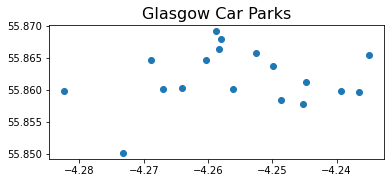

In [6]:
gdf.plot()
plt.title("Glasgow Car Parks", fontsize=16)
plt.show()

### Asking Questions of this data

**We go to a given car park, and find that the car park has been closed. We want to find the nearest car park to this location**

In [22]:
# We use the 'nearest_points' operation from the Shapely library
from shapely.ops import nearest_points

def get_nearest(carpark):
    point = carpark.geometry
    idx = carpark.name
    multipoint = gdf.drop(idx, axis=0).geometry.unary_union  # drop the current index and use unary_union op
    _, nearest_geom = nearest_points(point, multipoint)
    return gdf[gdf.geometry == nearest_geom]['name'].item()

gdf['nearest_car_park'] = gdf.apply(get_nearest, axis=1)
gdf.head()

,name,latitude,longitude,spaces,geometry,nearest_car_park
0,Glasgow - SECC,55.859890,-4.282341,1090,POINT (-4.28234 55.85989),Kinning Park - Shields Road Park
1,Glasgow - Duke Street Car Park,55.859662,-4.236529,1081,POINT (-4.23653 55.85966),Glasgow - High Street Pay & Disp
2,Glasgow - Dundasvale Car Park 2,55.869168,-4.258814,37,POINT (-4.25881 55.86917),Glasgow - Dundasvale Car Park 1
3,Glasgow - Royal Infirmary Car Pa,55.865487,-4.234978,1749,POINT (-4.23498 55.86549),Glasgow - Duke Street Car Park
4,Glasgow - George Street Car Park,55.861238,-4.244722,1289,POINT (-4.24472 55.86124),"Glasgow - Candleriggs - 37, Albi"


In [8]:
gdf[['name', 'nearest_car_park']]

,name,nearest_car_park
0,Glasgow - SECC,Kinning Park - Shields Road Park
1,Glasgow - Duke Street Car Park,Glasgow - High Street Pay & Disp
2,Glasgow - Dundasvale Car Park 2,Glasgow - Dundasvale Car Park 1
3,Glasgow - Royal Infirmary Car Pa,Glasgow - Duke Street Car Park
4,Glasgow - George Street Car Park,"Glasgow - Candleriggs - 37, Albi"
5,Glasgow - High Street Pay & Disp,Glasgow - Duke Street Car Park
6,Glasgow - The Glasshouse Car Par,"Glasgow - Candleriggs - 37, Albi"
7,"Glasgow - Candleriggs - 37, Albi",Glasgow - The Glasshouse Car Par
8,"Glasgow - Waterloo Street- 99,",Glasgow - Cadogan Square Car Par
9,Glasgow - Sauchiehall Street - 1,Glasgow - Cambridge Street Car P


In [23]:
# create leaflet web map centered/zoomed to Glasgow
GLASGOW = (55.871, -4.2518)
ZOOM_START = 13
M = folium.Map(location=GLASGOW, zoom_start=ZOOM_START, tiles='cartodbpositron')

# add red markers for each car park
cols = ['latitude', 'longitude', 'name', 'spaces']
for lat, lng, name, spaces in gdf[cols].values:  
    folium.CircleMarker(location=(float(lat), float(lng)), radius=5, color='#dc143c',
                        fill=True, fill_color='#dc143c', tooltip=f"{name}: <br/><b>{spaces}</b> spaces").add_to(M)

In [10]:
# show the Map
M

### Reading GeoJSON: Public Parks, Glasgow


Open Dataset - a GeoJSON file with data about public parks in Glasgow.

http://opendata.uksouth.cloudapp.azure.com/dataset/e42cc638-989b-43e1-a666-8f9ccc54fe88/resource/965b2846-8081-429e-a44c-8cd70115b8d4/download/country-parks.geojson

In [24]:
url = 'http://opendata.uksouth.cloudapp.azure.com/dataset/e42cc638-989b-43e1-a666-8f9ccc54fe88/resource/965b2846-8081-429e-a44c-8cd70115b8d4/download/country-parks.geojson'

gdf2 = gpd.read_file(url)

In [25]:
centre = (55.8, -4.2518)
M = folium.Map(location=centre, zoom_start=11, tiles='cartodbpositron')

# show the parks on the map
folium.GeoJson(
    gdf2[['NAME', 'geometry']].to_json(), # convert the GeoDataFrame to GeoJSON
    name="Parks in Glasgow",
    show=True,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NAME'],
        aliases=['Park name:'],
    )    
).add_to(M)


In [13]:
M

Just to show we can, the car park points can be added to the same map.

In [ ]:
# add red markers for each car park
cols = ['latitude', 'longitude', 'name', 'spaces']
for lat, lng, name, spaces in gdf[cols].values:  
    folium.CircleMarker(location=(lat, lng), radius=5, color='#dc143c',
                        fill=True, fill_color='#dc143c', tooltip=f"{name}: <br/><b>{spaces}</b> spaces").add_to(M)

In [ ]:
M

In [ ]:
gdf2

,PERIMETER,SITE_HA,PA_CODE,NAME,AREA,geometry
0,5458.625,150.67,8714,Pollok Country Park,1506676.000,"POLYGON ((-4.29471 55.83122, -4.29470 55.83093..."
1,7979.266,169.14,10249,Cathkin Braes Country Park,1691406.031,"POLYGON ((-4.21028 55.80315, -4.20988 55.80042..."
2,14864.439,552.31,10251,Dams to Darnley Country Park,5527717.037,"POLYGON ((-4.34482 55.80715, -4.34497 55.80694..."
3,8013.381,260.54,8698,Drumpellier Country Park,2605432.000,"POLYGON ((-4.07614 55.86599, -4.07610 55.86581..."


We can access the geometric centroid of each park using the `centroid` attribute that exists on a GeoSeries.

In [27]:
gdf2['geometry'].centroid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


0    POINT (-4.30645 55.83120)
1    POINT (-4.22505 55.79688)
2    POINT (-4.35711 55.79914)
3    POINT (-4.07614 55.86594)
dtype: geometry

This can be plotted on the Folium map

In [28]:
for i, row in gdf2.iterrows():
    centroid = row.geometry.centroid.coords[0]
    print(centroid)
    folium.CircleMarker(location=centroid[::-1], radius=2, color='green',
                        fill=True, fill_color='pink').add_to(M)

(-4.306451238814201, 55.831196596211285)
(-4.225052023837822, 55.796877632007416)
(-4.357111649883653, 55.79913996219005)
(-4.076143899711402, 55.865935396568666)


In [16]:
M